---

<br>

# KBRI DeepLearning Study 11장

<br>

* Hands-On Machine Learning with Scikit-Learn and TensorFlow by Aurélien Géron
* 2부. 신경망과 딥러닝 - 11장. 심층 신경망 훈련하기
* 신경망 잘 훈련하기

<br>

* gradient
    * 초기화 -> 최근엔 HE, 르쿤.
    * 활성함수
    * BN
    * gradient clipping
* 재훈련
* Optimizer
* 규제, overfitting 방지 방법

<br>

<br>

* 가상환경 활성화 및 라이브러리 설치 

        # 가상환경 생성
        conda create -n [ENV_NAME] python=3.8
        
        # 가상환경 리스트 확인
        conda env list
        
        # 가상환경 내 패키지 확인
        conda list -n [ENV_NAME]
        
        # 가상환경 활성화 & 비활성화
        conda activate th_kbri
        conda deactivate th_kbri
        
        # library 설치
        conda install numpy
        conda install pandas
        conda install matplotlib
        conda install seaborn
        conda install scipy
        conda install scikit-learn
        conda install tensorflow
        pip install pydot
        pip install graphviz
       
<br>

In [1]:
# 파이썬 ≥3.5 필수
import sys
assert sys.version_info >= (3, 5)

# 사이킷런 ≥0.20 필수
import sklearn
assert sklearn.__version__ >= "0.20"
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# 텐서플로 ≥2.0 필수
import tensorflow as tf
assert tf.__version__ >= "2.0"
from tensorflow.keras.utils import plot_model

# 공통 모듈 임포트
import numpy as np
import os
import copy

# 노트북 실행 결과를 동일하게 유지하기 위해
np.random.seed(42)

import pandas as pd

# 깔끔한 그래프 출력을 위해
import seaborn as sns
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

In [2]:
 tf.__version__

'2.2.1'

<br>

## 11장. 심층 신경망 훈련하기

<br>

<br>

### Vanishing Gradient & Exploding Gradient

<br>

<br>

* **Vanishing Gradient (그레이디언트 소실)**
    * 러닝 알고리즘이 하위층으로 진행될수록 gradient가 점점 작아지는 경우
    * 경사 하강법(gradient desent)이 하위층의 연결 가중치를 변경시키지 못하게 된다. 

<br>

* **Exploding Gradient (그레이디언트 폭주)**
    * 러닝 알고리즘이 하위층으로 진행될수록 gradient가 점점 커지는 경우 
    * 경사 하강법(gradient desent)이 비정상적으로 큰 가중치로 갱신을 시킨다.
    
<br>

* Logistic Sigmoid Activation Function(평균이 0.5)과 normal distribution(평균 0, 표준편차 1)을 통한 가중치 초기화 방법에 의해 Gradient가 불안정해질 수 있음.


* 신경망에서 층이 진행될수록 분산이 커지게 되어 뒤 층에서 활성화 함수가 0이나 1로 수렴하게된다.


* Logistic Sigmoid 함수의 특성상 입력이 0, 1로 수렴하게 되면 기울기가 0에 가까워진다. (아래 그림 참조)

<br>

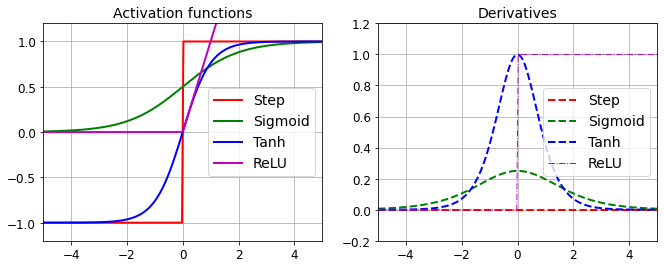

In [3]:
def sigmoid(z):
    return 1/(1+np.exp(-z))
    
def relu(z):
    return np.maximum(0, z)
    
def sign(z):
    return np.sign(z)

def tanh(z):
    return np.tanh(z)

def derivative(f, z, eps=0.000001):
    return (f(z + eps) - f(z - eps))/(2 * eps)

z = np.linspace(-5, 5, 200)

plt.figure(figsize=(11,4))

plt.subplot(121)
plt.plot(z, sign(z), "r-", linewidth=2, label="Step")
plt.plot(z, sigmoid(z), "g-", linewidth=2, label="Sigmoid")
plt.plot(z, tanh(z), "b-", linewidth=2, label="Tanh")
plt.plot(z, relu(z), "m-", linewidth=2, label="ReLU")
plt.grid(True)
plt.legend(loc="center right", fontsize=14)
plt.title("Activation functions", fontsize=14)
plt.axis([-5, 5, -1.2, 1.2])

plt.subplot(122)
plt.plot(z, derivative(np.sign, z), "r--", linewidth=2, label="Step")
plt.plot(z, derivative(sigmoid, z), "g--", linewidth=2, label="Sigmoid")
plt.plot(z, derivative(np.tanh, z), "b--", linewidth=2, label="Tanh")
plt.plot(z, derivative(relu, z), "m-.", linewidth=1, label="ReLU")
plt.grid(True)
plt.legend(loc="center right", fontsize=14)
plt.title("Derivatives", fontsize=14)
plt.axis([-5, 5, -0.2, 1.2])

plt.show()

<br>

#### 불안정한 Gradient에 대한 초기화 방법 (Glorot, LuCun, He Initialization)

<br>

<br>

* 불안정한 gradient를 방지하기 위해서는 각 층의 입력의 분산과 출력의 분산이 동일해야하며 그레이디언트의 분산이 동일해야한다.


* 한 층의 입력 개수(fan-in, 팬-인), 출력 개수(fan-out, 팬-아웃)이 같으면 위 두 가지가 가능할 수 있다. (층의 입력 개수 및 출력 개수 이므로, 층마다 값이 달라진다.)


* 또는 대안적으로, 각 층의 연결 가중치 초기화 방법을 보완할 수 있다. 이 방법으로 Glorot, LuCun, He 초기화 방법 등이 있다.



* 다양한 초기화 방법 코드에는 이 링크 (https://keras.io/ko/initializers/) 를 참조한다.

<br>

<br>

##### Glorot Initialization 또는 Xavier Initialization

<br>

* 활성화 함수가 없거나, 하이퍼볼릭 탄젠트(tanh, hyperbolic tangent), 로지스틱(Logistic Sigmoid), 소프트맥스(SoftMax) 함수 등에는,


* $fan_{avg} = \frac{(fan_{in}+fan_{out})}{2} $ 일 때,


* 평균이 0, 분산이 $\sigma^{2} = \frac{1}{fan_{out}}$ 인 정규 분포 (normal dist)


* $r = \sqrt{\frac{3}{fan_{avg}}}$ 일때, $-r$과 $+r$ 사이의 균등 분포 (uniform dist)

<br>

<br>

##### Lucun Initialization

<br>

* SELU 활성화 함수에는, 



* 평균이 0, 분산이 $\sigma^{2} = \frac{1}{fan_{out}}$ 인 정규 분포 (normal dist)


* $r = \sqrt{\frac{3}{fan_{in}}}$ 일때, $-r$과 $+r$ 사이의 균등 분포 (uniform dist)

<br>

<br>

##### HE Initialization

<br>

* ReLu, ELU 등의 활성화 함수에는,


* 평균이 0, 분산이 $\sigma^{2} = \frac{2}{fan_{in}}$ 인 정규 분포 (normal dist)


* $r = \sqrt{3\sigma^{2}}$ 일때, $-r$과 $+r$ 사이의 균등 분포 (uniform dist)

<br>

        # Keras 층을 만들 때, 다음과 같이 초기화 방법에 넣을 수 있음.
        keras.layers.Dense(10, activation="relu", 
                           kernel_initializer="he_normal") # "he_uniform"
                           
        # 만약 fan-out 기반의 균등분포 HE 초기화를 사용하고자 한다면, 
        he_avg_init = keras.initializers.VarianceScaling(scale=2., 
                            mode="fan_avg", distribution="uniform")
        keras.layers.Dense(10, activation="sigmoid", 
                           kernel_initializer="he_avg_init") 
        
                    
        
<br>

<br>

#### 수렴하지 않는 활성화 함수


<br>

<br>

* 활성화 함수에는 Step, Sign, Logistic Sigmoid, Tahn, ReLU, Softmax 등 다양한 것이 있다.


* 최근 가장 좋은 것으로 알려져있는 것은 ReLu이다. 그러나 ReLu도 훈련 중 일부 뉴런이 0 이외의 값을 출력하지 않는 문제가 발생할 수 있다. (dying ReLU)


* 입력의 가중치 합이 음수가 되면 ReLU 함수의 gradient가 0이 되기 때문이다.


* 대안적으로 LeakyReLu 같은 변종 ReLU 함수를 사용할 수 있다. 

<br>

옵티마이저
1) SGD
2) Momentum
3) NAG
4) ADAGRAD
5) ADam 
등...

요새는... ADAM = ADAGRAD
 NADAM
 웬만하면 ADAM

<br>

### Optimizer, Activation, Initializer를 조합하여 모델을 만들고 평가하기

<br>

* 수렴이 언제부터 시작되나요? 

* 모델의 성능은 어떤가요?

* 전체 훈련 속도는 몇인가요? 

<br>



----
#### [ 0 ] 

<br>

* CIFAR10 데이터셋을 불러오세요. keras.datasets.cifar10.load_ data()를 사용하여 데이터를 적재할 수 있습니다.
* 데이터셋의 차원을 확인해봅시다.
* Dense layer을 사용하기 때문에 데이터의 shape을 1차원으로 바꿔야 합니다. ( np.reshape(데이터, (바꿀shape) ) 사용)

<br>

In [4]:
# cifar dataset 불러오기
# 아래의 코드를 통해 train set, test set이 분리되어 들어간다.
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((50000, 32, 32, 3), (50000, 1), (10000, 32, 32, 3), (10000, 1))

In [5]:
# reshape
# x_train = np.reshape(x_train, 
#                      (50000, 32*32*3))
x_train = np.reshape(x_train, 
                     (x_train.shape[0], x_train.shape[1]*x_train.shape[2]*x_train.shape[3]))
x_test = np.reshape(x_test, 
                    (x_test.shape[0], x_test.shape[1]*x_test.shape[2]*x_test.shape[3]))

In [6]:
# normalization
# asix 0 -> 한 obsevation에서가 아닌 각 feature들에서 normalization을 해야하는 것이므로 
# axis는 0으로. https://www.sharpsightlabs.com/blog/numpy-mean/참조 
# keepdims=True -> input의 dimension과 output의 dimension이 동일하도록. 
pixel_means = x_train.mean(axis=0, keepdims=True)
pixel_stds = x_train.std(axis=0, keepdims=True)
x_train_scaled = (x_train - pixel_means) / pixel_stds
x_test_scaled = (x_test - pixel_means) / pixel_stds

In [7]:
x_test_scaled.shape

(10000, 3072)

----
#### [ 1 ]

<br>

* **100**개의 뉴런을 가진 **은닉층** **20개**를 쌓아 심층 신경망을 만듭니다.
* 모든 은닉층의 initializer는 **He 초기화**를, 활성화 함수는 **Relu** 함수를 사용합니다.
* 출력층은 **10개**의 뉴런과 **소프트맥스 활성화** 함수를 사용합니다. 
* 출력층에서는 Initializer를 사용하지 않습니다. 

<br>

* HE 초기화: ReLu, ELU 등의 활성화 함수에 사용
* 평균이 0, 분산이 $\sigma^{2} = \frac{2}{fan_{in}}$ 인 정규 분포 (normal dist)

In [8]:
# 모델 구조 정의
def make_model_1():
    model = tf.keras.models.Sequential() # Sequential 모델
    model.add(tf.keras.layers.InputLayer((32*32*3))) # Input layer

    for _ in range(20): # dense layer. 총 20개
        model.add(tf.keras.layers.Dense(100, activation="relu", 
                                        kernel_initializer='he_normal'))  
        # kernel initializer는 he_normal
        
    model.add(tf.keras.layers.Dense(10, activation="softmax"))
    # cifar는 10개 범주에 대한 단일 integer class로 결과값이 구분되므로 
    # 출력층의 activation은 softmax
    return model

----
##### 1-1 )

<br>

* 옵티마이저는 **Adam**를 사용합니다. 
* 모델 저장 이름은 **1-1_model.h5** 로 합니다.

<br>

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               307300    
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_3 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_4 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_5 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_6 (Dense)              (None, 100)               1

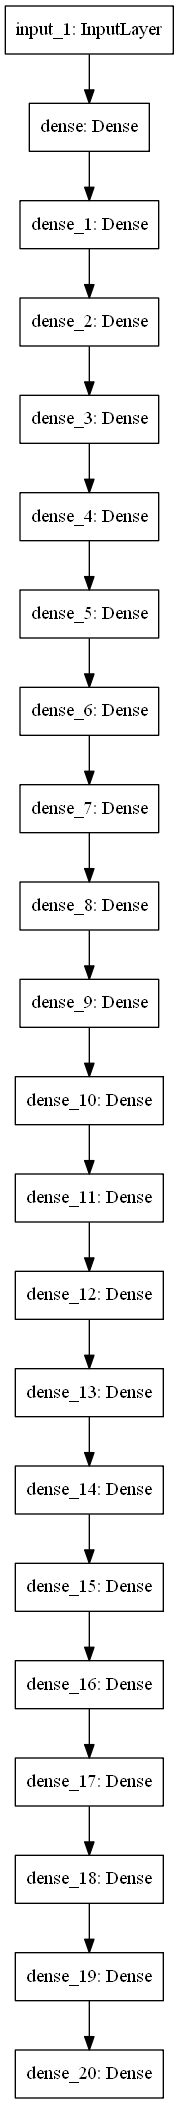

In [9]:
#모델 생성
model=make_model_1()
model.summary()
plot_model(model)

In [10]:
# 모델 컴파일
model.compile(loss="sparse_categorical_crossentropy", 
              # label이 one-hot encoding이 아닌 단일 integer로 나올때 space_categorical_crossentropy 사용
              # label이 one-hot encoding이면 categorical_crossentropy 사용
              optimizer=tf.keras.optimizers.Adam(),
              # Optimizer는 SGD가 아닌 Adam 사용
              # Adam parameter는 Adam(beta_1=0.9, beta_2=0.999)이 좋다고 함.
              metrics=["accuracy"])

# 콜백 선언
  # best model만 저장하는 callback
model_checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("1-1_model.h5", 
                                                         save_best_only=True)
  # 훈련이 효과가 없으면 early stopping하는 callback
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10,
                                                     restore_best_weights=True)

  # tensorboard 사용을 위한 callback
tensorboard_cb = tf.keras.callbacks.TensorBoard('logs')

In [11]:
# 훈련 전 모델 평가
model_test = model.evaluate(x_test_scaled, y_test)
print(model_test)

313/313 [==============================] - 1s 2ms/step - loss: 2.4233 - accuracy: 0.1064
[2.4233107566833496, 0.10639999806880951]


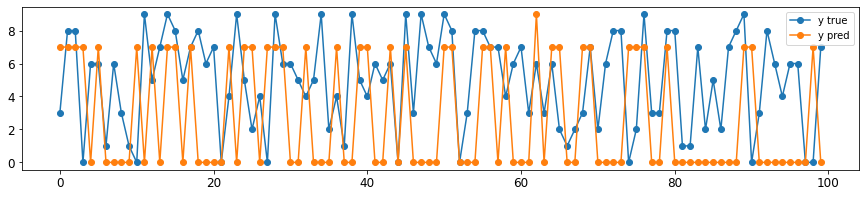

In [12]:
# 훈련 전 모델 예측
y_pred = model.predict(x_test_scaled)
y_pred_class = np.argmax(y_pred, axis=1)
y_pred_class = y_pred_class.tolist()

plt.figure(figsize=(15,3))
plt.plot(y_test[:100], marker='o')
plt.plot(y_pred_class[:100], marker='o')
plt.legend(('y true', 'y pred'))

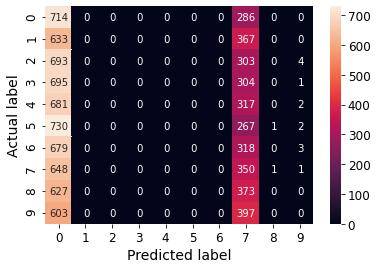

In [13]:
g = sns.heatmap(confusion_matrix(y_test,y_pred_class),annot=True,fmt='2.0f')
g.set_ylabel('Actual label');
g.set_xlabel('Predicted label');

In [14]:
print(classification_report(y_test, y_pred_class))

              precision    recall  f1-score   support

           0       0.11      0.71      0.19      1000
           1       0.00      0.00      0.00      1000
           2       0.00      0.00      0.00      1000
           3       0.00      0.00      0.00      1000
           4       0.00      0.00      0.00      1000
           5       0.00      0.00      0.00      1000
           6       0.00      0.00      0.00      1000
           7       0.11      0.35      0.16      1000
           8       0.00      0.00      0.00      1000
           9       0.00      0.00      0.00      1000

    accuracy                           0.11     10000
   macro avg       0.02      0.11      0.03     10000
weighted avg       0.02      0.11      0.03     10000



C:\ProgramData\Anaconda3\envs\th_kbri\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [15]:
# 모델 훈련
model.fit(x_train_scaled, y_train, 
          validation_split=0.2,
          epochs=20,
          callbacks=[model_checkpoint_cb, early_stopping_cb, tensorboard_cb])

Epoch 1/20
1250/1250 [==============================] - 13s 10ms/step - loss: 1.9727 - accuracy: 0.2472 - val_loss: 1.8867 - val_accuracy: 0.2749
Epoch 2/20
1250/1250 [==============================] - 12s 10ms/step - loss: 1.8180 - accuracy: 0.3172 - val_loss: 1.7983 - val_accuracy: 0.3331
Epoch 3/20
1250/1250 [==============================] - 13s 11ms/step - loss: 1.7395 - accuracy: 0.3581 - val_loss: 1.7073 - val_accuracy: 0.3674
Epoch 4/20
1250/1250 [==============================] - 13s 10ms/step - loss: 1.6749 - accuracy: 0.3875 - val_loss: 1.7004 - val_accuracy: 0.3909
Epoch 5/20
1250/1250 [==============================] - 12s 9ms/step - loss: 1.6279 - accuracy: 0.4129 - val_loss: 1.6947 - val_accuracy: 0.3918
Epoch 6/20
1250/1250 [==============================] - 13s 10ms/step - loss: 1.5920 - accuracy: 0.4261 - val_loss: 1.6547 - val_accuracy: 0.3925
Epoch 7/20
1250/1250 [==============================] - 13s 10ms/step - loss: 1.5533 - accuracy: 0.4408 - val_loss: 1.6174 - 

In [16]:
# 훈련 후 모델 평가
model1_1 = tf.keras.models.load_model('1-1_model.h5')
model_test = model1_1.evaluate(x_test_scaled, y_test)
print(model_test)

313/313 [==============================] - 1s 3ms/step - loss: 1.5011 - accuracy: 0.4658
[1.501147985458374, 0.4657999873161316]


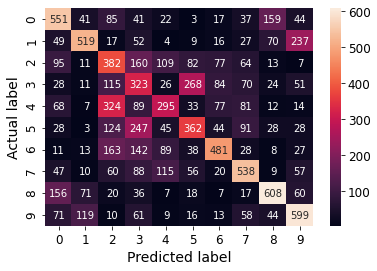

In [17]:
y_pred = model1_1.predict(x_test_scaled)
y_pred_class = np.argmax(y_pred, axis=1)
y_pred_class = y_pred_class.tolist()

g = sns.heatmap(confusion_matrix(y_test,y_pred_class),annot=True,fmt='2.0f')
g.set_ylabel('Actual label');
g.set_xlabel('Predicted label');

In [18]:
print(classification_report(y_test, y_pred_class))

              precision    recall  f1-score   support

           0       0.50      0.55      0.52      1000
           1       0.64      0.52      0.58      1000
           2       0.29      0.38      0.33      1000
           3       0.26      0.32      0.29      1000
           4       0.41      0.29      0.34      1000
           5       0.41      0.36      0.38      1000
           6       0.58      0.48      0.52      1000
           7       0.53      0.54      0.54      1000
           8       0.62      0.61      0.62      1000
           9       0.53      0.60      0.56      1000

    accuracy                           0.47     10000
   macro avg       0.48      0.47      0.47     10000
weighted avg       0.48      0.47      0.47     10000



----
##### 1-2 )

<br>

* 옵티마이저는 **Adam**을 사용합니다. Adam의 파라미터 **beta1**, **beta2**를 0.9, 0.999로 초기화 합니다. 
* 콜백 ModelCheckpoint의 저장 이름을 **1-2_model.h5**로 바꿉니다.

<br>

In [19]:
#모델 생성
model1=make_model_1()

# 모델 컴파일
model1.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(beta_1=0.9, beta_2=0.999),
              metrics=["accuracy"]) 

# 콜백 선언
model_checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("1-2_model.h5", 
                                                         save_best_only=True)
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10,
                                                     restore_best_weights=True)
tensorboard_cb = tf.keras.callbacks.TensorBoard('logs')

# 모델 훈련
model1.fit(x_train_scaled, y_train,
          validation_split=0.2,
          epochs=20,
          callbacks=[model_checkpoint_cb, early_stopping_cb, tensorboard_cb])

Epoch 1/20
1250/1250 [==============================] - 22s 18ms/step - loss: 1.9815 - accuracy: 0.2488 - val_loss: 1.9136 - val_accuracy: 0.2742
Epoch 2/20
1250/1250 [==============================] - 17s 13ms/step - loss: 1.8229 - accuracy: 0.3121 - val_loss: 1.8023 - val_accuracy: 0.3241
Epoch 3/20
1250/1250 [==============================] - 13s 10ms/step - loss: 1.7558 - accuracy: 0.3528 - val_loss: 1.7355 - val_accuracy: 0.3515
Epoch 4/20
1250/1250 [==============================] - 12s 10ms/step - loss: 1.6834 - accuracy: 0.3884 - val_loss: 1.6646 - val_accuracy: 0.4059
Epoch 5/20
1250/1250 [==============================] - 14s 11ms/step - loss: 1.6289 - accuracy: 0.4139 - val_loss: 1.6670 - val_accuracy: 0.4080
Epoch 6/20
1250/1250 [==============================] - 16s 13ms/step - loss: 1.5858 - accuracy: 0.4282 - val_loss: 1.6478 - val_accuracy: 0.4057
Epoch 7/20
1250/1250 [==============================] - 14s 11ms/step - loss: 1.5596 - accuracy: 0.4414 - val_loss: 1.6288 -

In [20]:
# 훈련 후 모델 평가
model1_2 = tf.keras.models.load_model('1-2_model.h5')
model_test = model1_2.evaluate(x_test_scaled, y_test)
print(model_test)

313/313 [==============================] - 1s 4ms/step - loss: 1.4987 - accuracy: 0.4784
[1.4987298250198364, 0.47839999198913574]


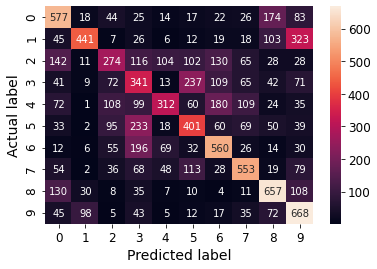

In [21]:
y_pred = model1_2.predict(x_test_scaled)
y_pred_class = np.argmax(y_pred, axis=1)
y_pred_class = y_pred_class.tolist()

g = sns.heatmap(confusion_matrix(y_test,y_pred_class),annot=True,fmt='2.0f')
g.set_ylabel('Actual label');
g.set_xlabel('Predicted label');

In [22]:
print(classification_report(y_test, y_pred_class))

              precision    recall  f1-score   support

           0       0.50      0.58      0.54      1000
           1       0.71      0.44      0.55      1000
           2       0.39      0.27      0.32      1000
           3       0.29      0.34      0.31      1000
           4       0.52      0.31      0.39      1000
           5       0.40      0.40      0.40      1000
           6       0.50      0.56      0.53      1000
           7       0.57      0.55      0.56      1000
           8       0.56      0.66      0.60      1000
           9       0.46      0.67      0.54      1000

    accuracy                           0.48     10000
   macro avg       0.49      0.48      0.47     10000
weighted avg       0.49      0.48      0.47     10000



----
#### [ 2 ]

<br>

* **100**개의 뉴런을 가진 **은닉층** **20개**를 쌓아 심층 신경망을 만듭니다.
* 모든 은닉층의 initializer는 **He 초기화**를, 활성화 함수는 **Elu** 함수를 사용합니다.
* 출력층은 **10개**의 뉴런과 **소프트맥스 활성화** 함수를 사용합니다. 
* 출력층에서는 **initializer**를 사용하지 않습니다. 

<br>

In [23]:
def make_model_2():
    model = tf.keras.models.Sequential() # Sequential 모델
    model.add(tf.keras.layers.InputLayer((32*32*3))) # Input layer

    for _ in range(20): # dense layer. 총 20개
        model.add(tf.keras.layers.Dense(100, activation="elu", 
                                        kernel_initializer='he_normal'))  
        
    model.add(tf.keras.layers.Dense(10, activation="softmax"))
    return model

<br>

##### 2-1 )

<br>

* 옵티마이저는 **Adam**을 사용합니다. Adam의 파라미터 **beta1**, **beta2**를 0.9, 0.999로 초기화 합니다. 
* 콜백 ModelCheckpoint의 저장 이름을 **2-1_model.h5**로 바꿉니다.

<br>

In [24]:
model2 = make_model_2()

# 모델 컴파일
model2.compile(loss="sparse_categorical_crossentropy", 
              optimizer=tf.keras.optimizers.Adam(beta_1=0.9, beta_2=0.999),
              metrics=["accuracy"])

# 콜백 선언
  # best model만 저장하는 callback
model_checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("2-1_model.h5", 
                                                         save_best_only=True)
  # 훈련이 효과가 없으면 early stopping하는 callback
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10,
                                                     restore_best_weights=True)

  # tensorboard 사용을 위한 callback
tensorboard_cb = tf.keras.callbacks.TensorBoard('logs')

In [25]:
# 모델 훈련
model2.fit(x_train_scaled, y_train, 
          validation_split=0.2,
          epochs=20,
          callbacks=[model_checkpoint_cb, early_stopping_cb, tensorboard_cb])

Epoch 1/20
1250/1250 [==============================] - 18s 14ms/step - loss: 1.9432 - accuracy: 0.2974 - val_loss: 1.7962 - val_accuracy: 0.3613
Epoch 2/20
1250/1250 [==============================] - 12s 10ms/step - loss: 1.7365 - accuracy: 0.3753 - val_loss: 1.7267 - val_accuracy: 0.3944
Epoch 3/20
1250/1250 [==============================] - 14s 11ms/step - loss: 1.6657 - accuracy: 0.4063 - val_loss: 1.6817 - val_accuracy: 0.4127
Epoch 4/20
1250/1250 [==============================] - 15s 12ms/step - loss: 1.5989 - accuracy: 0.4331 - val_loss: 1.6637 - val_accuracy: 0.4163
Epoch 5/20
1250/1250 [==============================] - 17s 13ms/step - loss: 1.5612 - accuracy: 0.4487 - val_loss: 1.5985 - val_accuracy: 0.4415
Epoch 6/20
1250/1250 [==============================] - 13s 10ms/step - loss: 1.5251 - accuracy: 0.4616 - val_loss: 1.6458 - val_accuracy: 0.4245
Epoch 7/20
1250/1250 [==============================] - 12s 9ms/step - loss: 1.4801 - accuracy: 0.4787 - val_loss: 1.5944 - 

In [26]:
# 훈련 후 모델 평가 및 예측
model2_1 = tf.keras.models.load_model('2-1_model.h5')
model2_1.evaluate(x_test_scaled, y_test)

313/313 [==============================] - 1s 4ms/step - loss: 1.5010 - accuracy: 0.4784


[1.501031517982483, 0.47839999198913574]

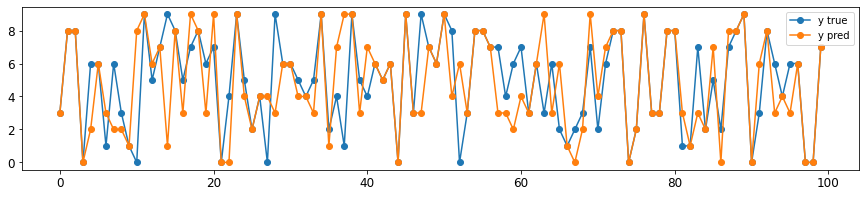

In [27]:
# 훈련 후 모델 예측
y_pred = model2_1.predict(x_test_scaled)
y_pred_class = np.argmax(y_pred, axis=1)
y_pred_class = y_pred_class.tolist()

plt.figure(figsize=(15,3))
plt.plot(y_test[:100], marker='o')
plt.plot(y_pred_class[:100], marker='o')
plt.legend(('y true', 'y pred'))

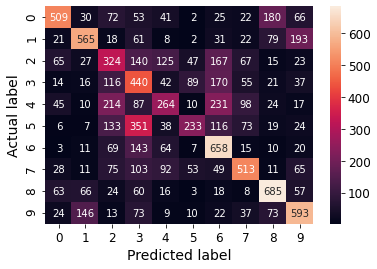

In [28]:
g = sns.heatmap(confusion_matrix(y_test,y_pred_class),annot=True,fmt='2.0f')
g.set_ylabel('Actual label');
g.set_xlabel('Predicted label');

In [29]:
print(classification_report(y_test, y_pred_class))

              precision    recall  f1-score   support

           0       0.65      0.51      0.57      1000
           1       0.64      0.56      0.60      1000
           2       0.31      0.32      0.31      1000
           3       0.29      0.44      0.35      1000
           4       0.38      0.26      0.31      1000
           5       0.51      0.23      0.32      1000
           6       0.44      0.66      0.53      1000
           7       0.56      0.51      0.54      1000
           8       0.61      0.69      0.65      1000
           9       0.54      0.59      0.57      1000

    accuracy                           0.48     10000
   macro avg       0.49      0.48      0.47     10000
weighted avg       0.49      0.48      0.47     10000



<br>

##### 2-2 )

<br>

* 옵티마이저는 **Nadam**을 사용합니다. Ndam의 학습률을 **5e-5** 로 초기화합니다
* 콜백 ModelCheckpoint의 저장 이름을 **2-2_model.h5**로 바꿉니다.

<br>

In [30]:
model3 = make_model_2()

# 모델 컴파일
model3.compile(loss="sparse_categorical_crossentropy", 
              optimizer=tf.keras.optimizers.Nadam(lr=5e-5),
              metrics=["accuracy"])

# 콜백 선언
  # best model만 저장하는 callback
model_checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("2-2_model.h5", 
                                                         save_best_only=True)
  # 훈련이 효과가 없으면 early stopping하는 callback
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10,
                                                     restore_best_weights=True)

  # tensorboard 사용을 위한 callback
tensorboard_cb = tf.keras.callbacks.TensorBoard('logs')

In [31]:
# 모델 훈련
model3.fit(x_train_scaled, y_train, 
          validation_split=0.2,
          epochs=20,
          callbacks=[model_checkpoint_cb, early_stopping_cb, tensorboard_cb])

Epoch 1/20
1250/1250 [==============================] - 31s 25ms/step - loss: 2.1437 - accuracy: 0.2568 - val_loss: 1.8814 - val_accuracy: 0.3150
Epoch 2/20
1250/1250 [==============================] - 18s 15ms/step - loss: 1.7686 - accuracy: 0.3599 - val_loss: 1.7529 - val_accuracy: 0.3705
Epoch 3/20
1250/1250 [==============================] - 21s 16ms/step - loss: 1.6394 - accuracy: 0.4123 - val_loss: 1.6717 - val_accuracy: 0.4064
Epoch 4/20
1250/1250 [==============================] - 23s 18ms/step - loss: 1.5446 - accuracy: 0.4437 - val_loss: 1.6345 - val_accuracy: 0.4232
Epoch 5/20
1250/1250 [==============================] - 19s 15ms/step - loss: 1.4746 - accuracy: 0.4743 - val_loss: 1.6364 - val_accuracy: 0.4272
Epoch 6/20
1250/1250 [==============================] - 18s 15ms/step - loss: 1.4129 - accuracy: 0.4938 - val_loss: 1.5870 - val_accuracy: 0.4463
Epoch 7/20
1250/1250 [==============================] - 21s 17ms/step - loss: 1.3587 - accuracy: 0.5159 - val_loss: 1.6163 -

In [32]:
# 훈련 후 모델 평가 및 예측
model2_2 = tf.keras.models.load_model('2-2_model.h5')
model2_2.evaluate(x_test_scaled, y_test)

313/313 [==============================] - 2s 7ms/step - loss: 1.5677 - accuracy: 0.4438


[1.5677098035812378, 0.4438000023365021]

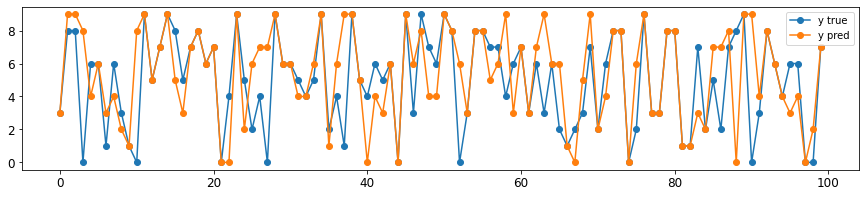

In [33]:
# 훈련 후 모델 예측
y_pred = model2_2.predict(x_test_scaled)
y_pred_class = np.argmax(y_pred, axis=1)
y_pred_class = y_pred_class.tolist()

plt.figure(figsize=(15,3))
plt.plot(y_test[:100], marker='o')
plt.plot(y_pred_class[:100], marker='o')
plt.legend(('y true', 'y pred'))

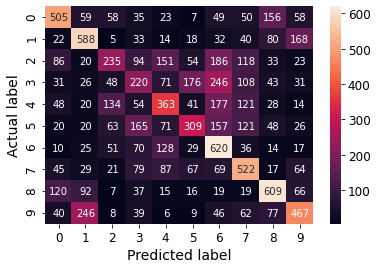

In [34]:
g = sns.heatmap(confusion_matrix(y_test,y_pred_class),annot=True,fmt='2.0f')
g.set_ylabel('Actual label');
g.set_xlabel('Predicted label');

In [35]:
print(classification_report(y_test, y_pred_class))

              precision    recall  f1-score   support

           0       0.54      0.51      0.52      1000
           1       0.52      0.59      0.55      1000
           2       0.37      0.23      0.29      1000
           3       0.27      0.22      0.24      1000
           4       0.39      0.36      0.38      1000
           5       0.43      0.31      0.36      1000
           6       0.39      0.62      0.48      1000
           7       0.44      0.52      0.48      1000
           8       0.55      0.61      0.58      1000
           9       0.50      0.47      0.48      1000

    accuracy                           0.44     10000
   macro avg       0.44      0.44      0.44     10000
weighted avg       0.44      0.44      0.44     10000



----
#### [ 3 ] 

<br>

* **100**개의 뉴런을 가진 **은닉층** **20개**를 쌓아 심층 신경망을 만듭니다.
* 모든 은닉층의 initializer는 **He 초기화**를, 활성화 함수는 **Elu** 함수를 사용합니다.
* 모든 은닉층의 다음층에서 BatchNormaliztion을 수행합니다. 
* 출력층은 **10개**의 뉴런과 **소프트맥스 활성화** 함수를 사용합니다. 
* 출력층에서는 **initializer**를 사용하지 않습니다. 
* 출력층 다음층에서는 BatchNormalization을 수행하지 않습니다.

<br>

In [36]:
def make_model_3():
    model = tf.keras.models.Sequential() # Sequential 모델
    model.add(tf.keras.layers.InputLayer((32*32*3))) # Input layer

    for _ in range(20): # dense layer. 총 20개
        model.add(tf.keras.layers.Dense(100, activation="elu", 
                                        kernel_initializer='he_normal'))  
        model.add(tf.keras.layers.BatchNormalization())
        
    model.add(tf.keras.layers.Dense(10, activation="softmax"))
    return model

* 옵티마이저는 **Nadam**을 사용합니다. Ndam의 학습률을 **5e-5** 로 초기화합니다
* 콜백 ModelCheckpoint의 저장 이름을 **3_model.h5**로 바꿉니다.

In [37]:
model4 = make_model_3()

# 모델 컴파일
model4.compile(loss="sparse_categorical_crossentropy", 
              optimizer=tf.keras.optimizers.Nadam(lr=5e-5),
              metrics=["accuracy"])

# 콜백 선언
  # best model만 저장하는 callback
model_checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("3_model.h5", 
                                                         save_best_only=True)
  # 훈련이 효과가 없으면 early stopping하는 callback
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10,
                                                     restore_best_weights=True)

  # tensorboard 사용을 위한 callback
tensorboard_cb = tf.keras.callbacks.TensorBoard('logs')

In [38]:
# 모델 훈련
model4.fit(x_train_scaled, y_train, 
          validation_split=0.2,
          epochs=20,
          callbacks=[model_checkpoint_cb, early_stopping_cb, tensorboard_cb])

Epoch 1/20
1250/1250 [==============================] - 53s 43ms/step - loss: 2.2914 - accuracy: 0.1999 - val_loss: 2.0128 - val_accuracy: 0.2801
Epoch 2/20
1250/1250 [==============================] - 29s 23ms/step - loss: 1.9525 - accuracy: 0.2995 - val_loss: 1.8380 - val_accuracy: 0.3406
Epoch 3/20
1250/1250 [==============================] - 32s 25ms/step - loss: 1.8425 - accuracy: 0.3390 - val_loss: 1.7562 - val_accuracy: 0.3694
Epoch 4/20
1250/1250 [==============================] - 30s 24ms/step - loss: 1.7752 - accuracy: 0.3642 - val_loss: 1.7022 - val_accuracy: 0.3963
Epoch 5/20
1250/1250 [==============================] - 33s 27ms/step - loss: 1.7174 - accuracy: 0.3849 - val_loss: 1.6554 - val_accuracy: 0.4116
Epoch 6/20
1250/1250 [==============================] - 29s 23ms/step - loss: 1.6755 - accuracy: 0.4021 - val_loss: 1.6178 - val_accuracy: 0.4235
Epoch 7/20
1250/1250 [==============================] - 32s 26ms/step - loss: 1.6329 - accuracy: 0.4169 - val_loss: 1.5905 -

In [39]:
# 훈련 후 모델 평가 및 예측
model3_0 = tf.keras.models.load_model('3_model.h5')
model3_0.evaluate(x_test_scaled, y_test)

313/313 [==============================] - 2s 6ms/step - loss: 1.4318 - accuracy: 0.4960


[1.4317865371704102, 0.4959999918937683]

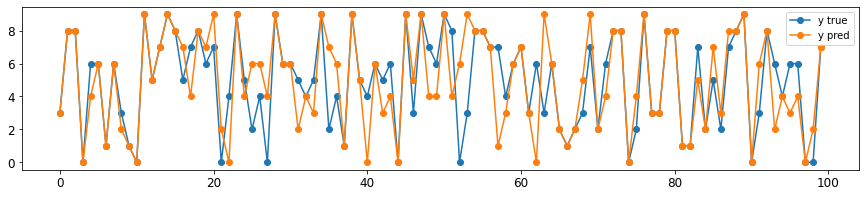

In [40]:
# 훈련 후 모델 예측
y_pred = model3_0.predict(x_test_scaled)
y_pred_class = np.argmax(y_pred, axis=1)
y_pred_class = y_pred_class.tolist()

plt.figure(figsize=(15,3))
plt.plot(y_test[:100], marker='o')
plt.plot(y_pred_class[:100], marker='o')
plt.legend(('y true', 'y pred'))

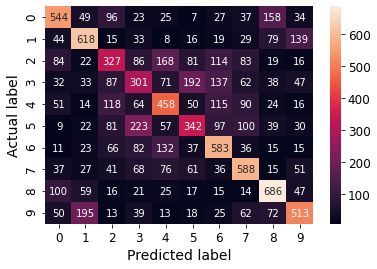

In [41]:
g = sns.heatmap(confusion_matrix(y_test,y_pred_class),annot=True,fmt='2.0f')
g.set_ylabel('Actual label');
g.set_xlabel('Predicted label');

In [42]:
print(classification_report(y_test, y_pred_class))

              precision    recall  f1-score   support

           0       0.57      0.54      0.55      1000
           1       0.58      0.62      0.60      1000
           2       0.38      0.33      0.35      1000
           3       0.32      0.30      0.31      1000
           4       0.44      0.46      0.45      1000
           5       0.42      0.34      0.38      1000
           6       0.50      0.58      0.54      1000
           7       0.53      0.59      0.56      1000
           8       0.60      0.69      0.64      1000
           9       0.56      0.51      0.54      1000

    accuracy                           0.50     10000
   macro avg       0.49      0.50      0.49     10000
weighted avg       0.49      0.50      0.49     10000



----
#### [ 4 ] 

<br>

* **100**개의 뉴런을 가진 **은닉층** **20개**를 쌓아 심층 신경망을 만듭니다.
* 모든 은닉층의 initializer는 **르쿤 초기화**를, 활성화 함수는 **Selu** 함수를 사용합니다.
* 출력층은 **10개**의 뉴런과 **소프트맥스 활성화** 함수를 사용합니다. 
* 출력층에서는 **initializer**를 사용하지 않습니다.

<br>
* **Selu**의 장점은 self-normalization. 각 층의 출력이 평균 0, 표준편차 1을 유지하기 때문에 vanishing gradient나 exploding gradient 문제를 피할 수 있음.
* **Selu** 사용 시 주의 사항
    * 모든 입력 feature는 평균 0, 표준펴차 1로 표준화되어야 함.
    * 모든 은닉층의 가중치는 lecun 정규 분포로 초기화되어야 함.
    * 네트워크는 일렬로 쌓은 층으로 구성되어야 함. 순환 신경망이나 skip connection (wide & deep model)과 같은 순차적이지 않은 구조에 Selu를 사용하면 자기 정규화되는 것을 보장하지 않음.


In [43]:
def make_model_4():
    model = tf.keras.models.Sequential() # Sequential 모델
    model.add(tf.keras.layers.InputLayer((32*32*3))) # Input layer

    for _ in range(20): # dense layer. 총 20개
        model.add(tf.keras.layers.Dense(100, activation="selu", 
                                        kernel_initializer='lecun_normal'))  
        # model.add(tf.keras.layers.BatchNormalization())
        
    model.add(tf.keras.layers.Dense(10, activation="softmax"))    
    return model

* 옵티마이저는 **Nadam**을 사용합니다. Ndam의 학습률을 **5e-5** 로 초기화합니다
* 콜백 ModelCheckpoint의 저장 이름을 **4_model.h5**로 바꿉니다.

In [44]:
model5 = make_model_4()

# 모델 컴파일
model5.compile(loss="sparse_categorical_crossentropy", 
              optimizer=tf.keras.optimizers.Nadam(lr=5e-5),
              metrics=["accuracy"])

# 콜백 선언
  # best model만 저장하는 callback
model_checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("4_model.h5", 
                                                         save_best_only=True)
  # 훈련이 효과가 없으면 early stopping하는 callback
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10,
                                                     restore_best_weights=True)

  # tensorboard 사용을 위한 callback
tensorboard_cb = tf.keras.callbacks.TensorBoard('logs')

In [45]:
# 모델 훈련
model5.fit(x_train_scaled, y_train, 
          validation_split=0.2,
          epochs=20,
          callbacks=[model_checkpoint_cb, early_stopping_cb, tensorboard_cb])

Epoch 1/20
1250/1250 [==============================] - 35s 28ms/step - loss: 1.9034 - accuracy: 0.3203 - val_loss: 1.7722 - val_accuracy: 0.3697
Epoch 2/20
1250/1250 [==============================] - 25s 20ms/step - loss: 1.6647 - accuracy: 0.4067 - val_loss: 1.6884 - val_accuracy: 0.3958
Epoch 3/20
1250/1250 [==============================] - 20s 16ms/step - loss: 1.5639 - accuracy: 0.4414 - val_loss: 1.6225 - val_accuracy: 0.4238
Epoch 4/20
1250/1250 [==============================] - 18s 14ms/step - loss: 1.4859 - accuracy: 0.4695 - val_loss: 1.5996 - val_accuracy: 0.4365
Epoch 5/20
1250/1250 [==============================] - 26s 21ms/step - loss: 1.4270 - accuracy: 0.4927 - val_loss: 1.5658 - val_accuracy: 0.4545
Epoch 6/20
1250/1250 [==============================] - 19s 15ms/step - loss: 1.3717 - accuracy: 0.5123 - val_loss: 1.5469 - val_accuracy: 0.4529
Epoch 7/20
1250/1250 [==============================] - 18s 15ms/step - loss: 1.3212 - accuracy: 0.5302 - val_loss: 1.5606 -

In [46]:
# 훈련 후 모델 평가 및 예측
model4_0 = tf.keras.models.load_model('4_model.h5')
model4_0.evaluate(x_test_scaled, y_test)

313/313 [==============================] - 1s 4ms/step - loss: 1.4967 - accuracy: 0.4849


[1.4967135190963745, 0.48489999771118164]

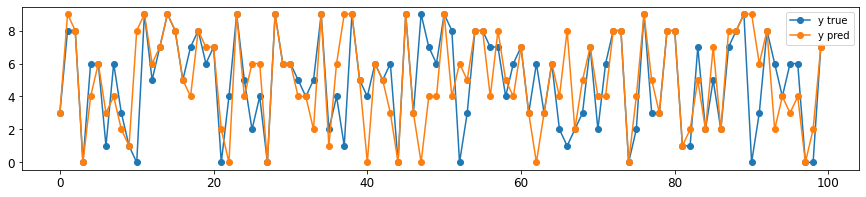

In [47]:
# 훈련 후 모델 예측
y_pred = model4_0.predict(x_test_scaled)
y_pred_class = np.argmax(y_pred, axis=1)
y_pred_class = y_pred_class.tolist()

plt.figure(figsize=(15,3))
plt.plot(y_test[:100], marker='o')
plt.plot(y_pred_class[:100], marker='o')
plt.legend(('y true', 'y pred'))

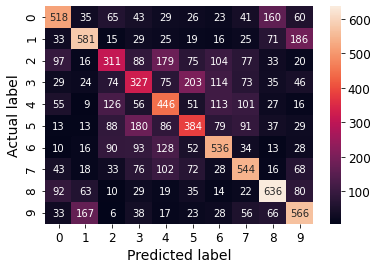

In [48]:
g = sns.heatmap(confusion_matrix(y_test,y_pred_class),annot=True,fmt='2.0f')
g.set_ylabel('Actual label');
g.set_xlabel('Predicted label');

In [49]:
print(classification_report(y_test, y_pred_class))

              precision    recall  f1-score   support

           0       0.56      0.52      0.54      1000
           1       0.62      0.58      0.60      1000
           2       0.38      0.31      0.34      1000
           3       0.34      0.33      0.33      1000
           4       0.40      0.45      0.42      1000
           5       0.41      0.38      0.40      1000
           6       0.51      0.54      0.52      1000
           7       0.51      0.54      0.53      1000
           8       0.58      0.64      0.61      1000
           9       0.52      0.57      0.54      1000

    accuracy                           0.48     10000
   macro avg       0.48      0.48      0.48     10000
weighted avg       0.48      0.48      0.48     10000



----
#### [ 5 ]

<br>

* 지금까지 만든 6가지 모델을 불러오고 평가해 봅니다.
* **tf.keras.models.load_model( )**을 통해 모델을 불러올 수 있습니다.
* **model.evaluate( )**를 통해 모든 모델을 평가해 봅니다.
* 불러오기 전에 아래 셀에서 각 모델의 특징을 간단히 메모하세요

<br>

<br>

* model_11: HE 초기화, Relu, Adam
* model_12: HE 초기화, Relu, Adam(beta_1=0.9, beta_2=0.999)
* model_21: HE 초기화, Elu, Adam(beta_1=0.9, beta_2=0.999)
* model_22: HE 초기화, Elu, Nadam(lr = 5e-5)
* model_3: HE 초기화, Elu, BatchNormalization, Nadam(lr = 5e-5)
* model_4: Lecun 초기화, Selu, Nadam(lr = 5e-5

<br>

In [50]:
# 모델 불러오기
model_11 = tf.keras.models.load_model('1-1_model.h5')
model_12 = tf.keras.models.load_model('1-2_model.h5')
model_21 = tf.keras.models.load_model('2-1_model.h5')
model_22 = tf.keras.models.load_model('2-2_model.h5')
model_3 = tf.keras.models.load_model('3_model.h5')
model_4 = tf.keras.models.load_model('4_model.h5')

In [51]:
# 모델 평가
m11_test = model_11.evaluate(x_test_scaled, y_test, batch_size =1)
m12_test = model_12.evaluate(x_test_scaled, y_test)
m21_test = model_21.evaluate(x_test_scaled, y_test)
m22_test = model_22.evaluate(x_test_scaled, y_test)
m3_test = model_3.evaluate(x_test_scaled, y_test)
m4_test = model_4.evaluate(x_test_scaled, y_test)
print("m11:", m11_test, "\n",
      "m12:", m12_test, "\n",
      "m21:", m21_test, "\n",
      "m22:", m22_test, "\n",
      "m3:", m3_test, "\n",
      "m4", m4_test)

313/313 [==============================] - 1s 3ms/step - loss: 1.4967 - accuracy: 0.4849
m11: [1.5011502504348755, 0.4657000005245209] 
 m12: [1.4987298250198364, 0.47839999198913574] 
 m21: [1.501031517982483, 0.47839999198913574] 
 m22: [1.5677098035812378, 0.4438000023365021] 
 m3: [1.4317865371704102, 0.4959999918937683] 
 m4 [1.4967135190963745, 0.48489999771118164]


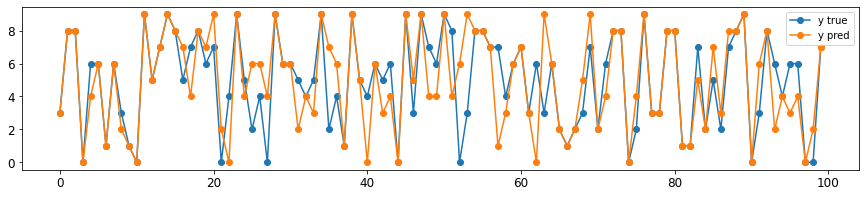

In [57]:
# 훈련 후 모델 예측
y_pred = model_3.predict(x_test_scaled)
y_pred_class = np.argmax(y_pred, axis=1)
y_pred_class = y_pred_class.tolist()

plt.figure(figsize=(15,3))
plt.plot(y_test[:100], marker='o')
plt.plot(y_pred_class[:100], marker='o')
plt.legend(('y true', 'y pred'))

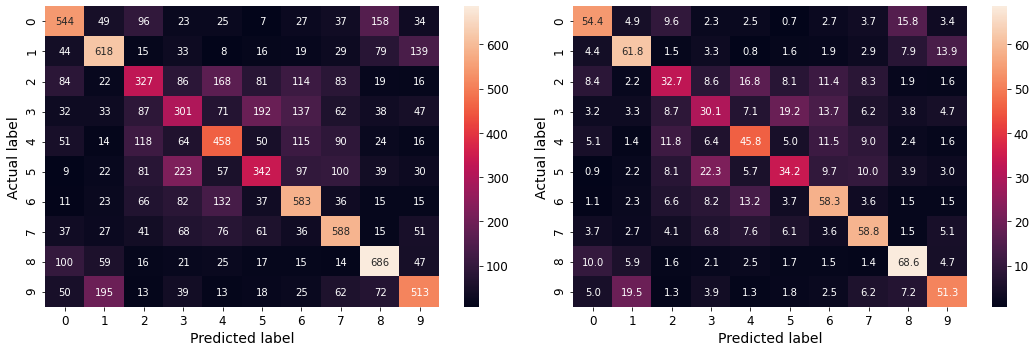

In [63]:
fig, axes = plt.subplots(ncols=2)
fig.set_size_inches(15,5)
sns.heatmap(confusion_matrix(y_test,y_pred_class),annot=True,fmt='2.0f', ax=axes[0])
axes[0].set_ylabel('Actual label');
axes[0].set_xlabel('Predicted label');
sns.heatmap(confusion_matrix(y_test,y_pred_class)/1000*100,annot=True,fmt='2.1f', ax=axes[1])
axes[1].set_ylabel('Actual label');
axes[1].set_xlabel('Predicted label');
plt.tight_layout()

In [60]:
print(classification_report(y_test, y_pred_class))

              precision    recall  f1-score   support

           0       0.57      0.54      0.55      1000
           1       0.58      0.62      0.60      1000
           2       0.38      0.33      0.35      1000
           3       0.32      0.30      0.31      1000
           4       0.44      0.46      0.45      1000
           5       0.42      0.34      0.38      1000
           6       0.50      0.58      0.54      1000
           7       0.53      0.59      0.56      1000
           8       0.60      0.69      0.64      1000
           9       0.56      0.51      0.54      1000

    accuracy                           0.50     10000
   macro avg       0.49      0.50      0.49     10000
weighted avg       0.49      0.50      0.49     10000

